In [1]:
import pytraj as pt
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import numpy as np
from statistics import mean
import pandas as pd
import os
import mdtraj as md
import pickle
from tqdm.notebook import trange, tqdm
import seaborn as sns

In [2]:
## read in domains 
with open ('../5gae_domains.pkl', 'rb') as fp:
    domains = pickle.load(fp)

_5gae_domains = domains + [
    {"a": 441, "b": 508, "n": "SecE",},
    {"a": 509, "b": 573, "n": "SecG",},
]

In [3]:
# load dict containing all pairwise forces
with open ('PAIRWISE_FORCES.pkl', 'rb') as fp:
    PAIRWISE_FORCES = pickle.load(fp)

In [4]:
PF = PAIRWISE_FORCES

# Data to Tables

In [5]:
def deltaF_to_table(key, refkey, top):
    """Filter out pairs of residues which are repulsive/attractive before/after applying an electric field
    Sort pairs by the change in interaction magnitude
    Returns a dataframe with residue pairs and their respective TMs
    NB: disregards pairs which switch from attractive to repulsive or vv
    """
    TABLE = {}

    residues = [r for r in top.residues]

    delta_pos_to_pos, delta_neg_to_neg, delta_pos_to_neg, delta_neg_to_pos = delta_F_case_by_case(key, refkey)

    for x, inttype in zip([delta_pos_to_pos, delta_neg_to_neg, delta_pos_to_neg, delta_neg_to_pos],
                       ["repulsion", "attraction"]):

        I, J = np.unravel_index(np.argsort(x, axis=None)[::-1],  ## sort ndcs from highest value to lowest
                                x.shape) 

        df = pd.DataFrame(
        )

        df["Res1"] = [residues[i] for i in tqdm(I, leave=False)]
        df["TM(res1)"] = [where_am_i(res, printout=False) for res in tqdm(I, leave=False)]
        df["Res2"] = [residues[j] for j in J]
        df["TM(res2)"] = [where_am_i(res, printout=False) for res in tqdm(J, leave=False)]
        df[f"Δ {inttype}"] = [x[i,j] for i, j in zip(I,J)]

        TABLE[inttype] = df

    return TABLE

In [6]:
def delta_F_case_by_case(key, refkey, check=False):
    """Calc deltaF case by case:
    For positive-positive interactions (i.e. repulsive before and after), we calc F_1 - F_0
    For negative-negative interactions (i.e. attractive before and after), we calc -(F_1 - F_0)
    (in this way, positive delta means attraction increased (got even more negative))
    For pos-neg/neg-pos interactions, we calc (F_1-F_0)/(-F_1+F_0) 
    (in this way, the delta is always positive 
    and counts the full swind in interaction from attractive to repulsive (or vv))
    
    returns delta_pos_to_pos, delta_neg_to_neg, delta_pos_to_neg, delta_neg_to_pos
    """
    global delta_pos_to_pos, delta_neg_to_neg, delta_pos_to_neg, delta_neg_to_pos
    ## cut out sequence-near interaction pairs
    F_ref = neighbor_cutoff(PF[refkey]['F_t_mean'], n_ignore_neighbors)
    F_key = neighbor_cutoff(PF[key]['F_t_mean'], n_ignore_neighbors)
    ## set up boolean arrays for F_ij index selection
    ## selecting matrix elements that are pos/neg for <key> and <refkey>
    neg_to_pos_bool = ((select_sign("pos", F_key)) > 0) \
                    & ((select_sign("neg", F_ref)) < 0)
    pos_to_neg_bool = ((select_sign("neg", F_key)) < 0) \
                    & ((select_sign("pos", F_ref)) > 0)
    pos_bool = ((select_sign("pos", F_key)) > 0) \
                    & ((select_sign("pos", F_ref)) > 0)
    neg_bool = ((select_sign("neg", F_key)) < 0) \
                    & ((select_sign("neg", F_ref)) < 0)
    
    delta_pos_to_pos = np.where(pos_bool, F_key, 0) \
                       - np.where(pos_bool, F_ref, 0)
    delta_neg_to_neg = - np.where(neg_bool, F_key, 0) \
                       + np.where(neg_bool, F_ref, 0)
    ## now effectively switch the sign for attractive interactions
    delta_pos_to_neg = - np.where(pos_to_neg_bool, F_key, 0) \
                       + np.where(pos_to_neg_bool, F_ref, 0)
    delta_neg_to_pos = np.where(neg_to_pos_bool, F_key, 0) \
                       - np.where(neg_to_pos_bool, F_ref, 0)
    if check: ## there should be 0 overlap btwn the arrays defined above
        for A in [delta_pos_to_pos,delta_neg_to_neg,delta_pos_to_neg,delta_neg_to_pos]:
            for B in [delta_pos_to_pos,delta_neg_to_neg,delta_pos_to_neg,delta_neg_to_pos]:
                if not np.array_equal(A,B):
                    print((A * B).sum())
    combined = [delta_pos_to_pos, delta_neg_to_neg, delta_pos_to_neg, delta_neg_to_pos]
    return combined

In [16]:
def neighbor_cutoff(array, n_neighbors):
    arr = array.copy()
    for i in range(len(arr)):
        for j in range(len(arr)):
            if abs(i-j) < n_neighbors:
                arr[i][j] = 0
    return arr

def pos_forces_only(array):
    arr = array.copy()
    arr[arr < 0] = 0
    return arr
def neg_forces_only(array):
    arr = array.copy()
    arr[arr > 0] = 0
    return arr

def select_sign(sel, arr):
    if sel == "pos":
        return pos_forces_only(arr)
    if sel == "neg":
        return neg_forces_only(arr)

In [17]:
## load topologies
for key in tqdm(PF):
    pdbf = "/".join((PF[key]["folder"][0]).split("/")[:-1]) + "/step1_pdbreader.pdb"
    PF[key]["mdtop"] = md.load(pdbf).top

  0%|          | 0/17 [00:00<?, ?it/s]

In [20]:
def where_am_i(res, printout=True):
    for dom in _5gae_domains:
        if res in range(dom["a"], dom["b"]+1):
            if printout:
                print(dom["n"])
            return dom["n"]

In [21]:
## apply cutoffs to disregard pairs with small change in ΔFij or flatten our large ΔFij for visualization
## and disregard pairs with small sequence distance
delta_force_lowercutoff = 15 # discard all ΔFij below this value
delta_force_uppercutoff = 40 # set all ΔFij above this value to delta_force_uppercutoff flat
n_ignore_neighbors = 25

In [22]:
## calculate change in pairwise force with respect to the V_TM = 0 case
refkey = "nof"
for key in tqdm(["posf", "negf"]):
    PF[key]["table"] = deltaF_to_table(key, refkey, PF[key]["mdtop"])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/328329 [00:00<?, ?it/s]

  0%|          | 0/328329 [00:00<?, ?it/s]

  0%|          | 0/328329 [00:00<?, ?it/s]

  0%|          | 0/328329 [00:00<?, ?it/s]

  0%|          | 0/328329 [00:00<?, ?it/s]

  0%|          | 0/328329 [00:00<?, ?it/s]

  0%|          | 0/328329 [00:00<?, ?it/s]

  0%|          | 0/328329 [00:00<?, ?it/s]

  0%|          | 0/328329 [00:00<?, ?it/s]

  0%|          | 0/328329 [00:00<?, ?it/s]

  0%|          | 0/328329 [00:00<?, ?it/s]

  0%|          | 0/328329 [00:00<?, ?it/s]

# Write to table

In [24]:
d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

def convert_mdres(res):
    return d[res.name] + str(res.resSeq)

In [25]:
key = "posf"

In [26]:
df = PF[key]["table"]["repulsion"][::2].copy()  #[:100]

## correct sign
if 'Δ attraction' in list(df):
    df['Δ attraction'] = -df['Δ attraction']

    df["Res1"] = [convert_mdres(res) for res in df["Res1"]]
df["Res2"] = [convert_mdres(res) for res in df["Res2"]]

## Residue pairs with strongest change in interaction for +200 mV

In [28]:
key = "posf"

for inttype in ["repulsion", "attraction"]:
    df = PF[key]["table"][inttype][::2].copy()  #[:100]

    ## adapt
    if 'Δ attraction' in list(df):
        df['Δ attraction'] = -df['Δ attraction']

    df["Res1"] = [convert_mdres(res) for res in df["Res1"]]
    df["Res2"] = [convert_mdres(res) for res in df["Res2"]]
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(df.loc[df["TM(res1)"].notna() & df["TM(res2)"].notna()][:15])
        print()
        print(df.loc[df["TM(res1)"].notna() & df["TM(res2)"].notna()][-15:])


    Res1 TM(res1)  Res2 TM(res2)  Δ repulsion
0    R34      TM1   R74     Plug   149.114066
4    R57     Plug  H205      TM5    76.041071
12  Q177      TM4   F25      TM1    57.320821
16  G134      TM3  W293      TM7    50.661850
20  I278      TM7  I191      TM5    46.836949
22  G138      TM3  W293      TM7    46.245855
24   L80      TM2  I135      TM3    45.923182
26  I189      TM5  F413     TM10    44.732059
32  V161      TM4  S132      TM3    41.520914
34  V116     SecE   R34      TM1    38.803308
36   S76     Plug   P42     Plug    37.696923
38  T289      TM7   F64     Plug    37.418972
42   L80      TM2  Q131      TM3    33.859676
44   F38      TM1  V116     SecE    33.119289
46   F67     Plug  L285      TM7    33.036855

        Res1 TM(res1)  Res2 TM(res2)  Δ repulsion
328290  R114      TM3   S33     SecG   -27.692965
328292   L23      TM1  V417     TM10   -29.072694
328296  A280      TM7  I322      TM8   -29.605154
328302   S37      TM1   A75     Plug   -30.522338
328304   L72 

## Residue pairs with strongest change in interaction for -200 mV

In [29]:
key = "negf"

for inttype in ["repulsion", "attraction"]:
    df = PF[key]["table"][inttype][::2].copy()  #[:100]

    ## adapt
    if 'Δ attraction' in list(df):
        df['Δ attraction'] = -df['Δ attraction']

    df["Res1"] = [convert_mdres(res) for res in df["Res1"]]
    df["Res2"] = [convert_mdres(res) for res in df["Res2"]]
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(df.loc[df["TM(res1)"].notna() & df["TM(res2)"].notna()][:15])
        print()
        print(df.loc[df["TM(res1)"].notna() & df["TM(res2)"].notna()][-15:])
        print()


    Res1 TM(res1)  Res2 TM(res2)  Δ repulsion
0    R74     Plug   R34      TM1   122.528401
8    F64     Plug  L285      TM7    72.087824
12  W293      TM7  G134      TM3    71.466470
16   R22      TM1  R181      TM4    56.389950
20  V161      TM4  S132      TM3    51.887839
26  Q177      TM4   F25      TM1    49.840196
28   I41     Plug  L164      TM4    48.260424
32   F64     Plug  T289      TM7    47.961053
34   F71     SecE  T368      TM9    47.095841
38  V235      TM6  M411     TM10    46.196080
40   S33     SecG  Q118      TM3    45.964161
44  V161      TM4  I133      TM3    44.411869
46  S282      TM7   I86      TM2    44.172243
48  A128      TM3   L80      TM2    43.987826
52  V165      TM4   L22     SecG    38.739731

        Res1 TM(res1)  Res2 TM(res2)  Δ repulsion
328290  L171      TM4   F78      TM2   -27.342410
328292   S87      TM2  L127      TM3   -27.600113
328296  R181      TM4   F25      TM1   -28.933930
328304  K431     TM10   K20      TM1   -31.860560
328306   L72 

# Write out network data for VMD Networkview

In [33]:
def array_to_network(arr, fname, delta_force_lowercutoff=15):
    """write network .dat files for cases with increased/decreased absolute Delta F_ij
    arrays are assumed to be non-negative!
    """
    ## visualize which delta_F values are cut out
    nonan = arr.copy()
    nonan[np.isnan(nonan)] = 0
    plt.plot(nonan.flatten())
    for cut in [delta_force_lowercutoff, delta_force_uppercutoff]:
        plt.hlines(y = [cut, ], xmin=0, xmax=len(nonan.flatten()), 
                  color="k", zorder=99)
    plt.show()

    arr[arr < delta_force_lowercutoff ] = np.nan
    arr[arr > delta_force_uppercutoff ] = delta_force_uppercutoff
    arr = arr / delta_force_uppercutoff
    arr = 1-arr ## rescale such that -log(C_ij) is large for large arr_ij
    arr[np.isnan(arr)] = 0
    ## introduce another cutoff to ensure that thick connections don't get ridiculously thick
    arr[(arr > 0) & (arr < 0.15)] = 0.15

    ## save network file for vmd networkview
    np.savetxt('temp', arr)
    ## atom selection for VMD
    ! echo "(name CA)" > name_ca
    ! cat name_ca temp > {fname}
    ! rm temp name_ca
    print(f"wrote network file {fname}")
    return arr



# Visualize increasing attraction/repulsion

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


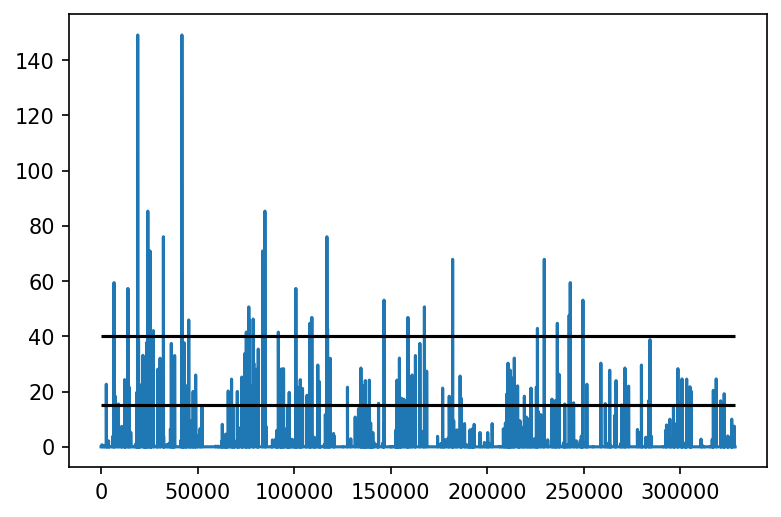

wrote network file posf_rep_incr.dat


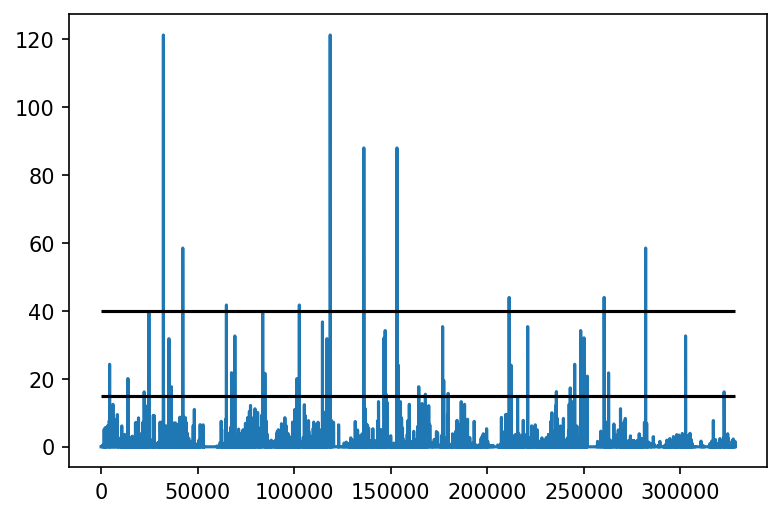

wrote network file posf_attr_incr.dat
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


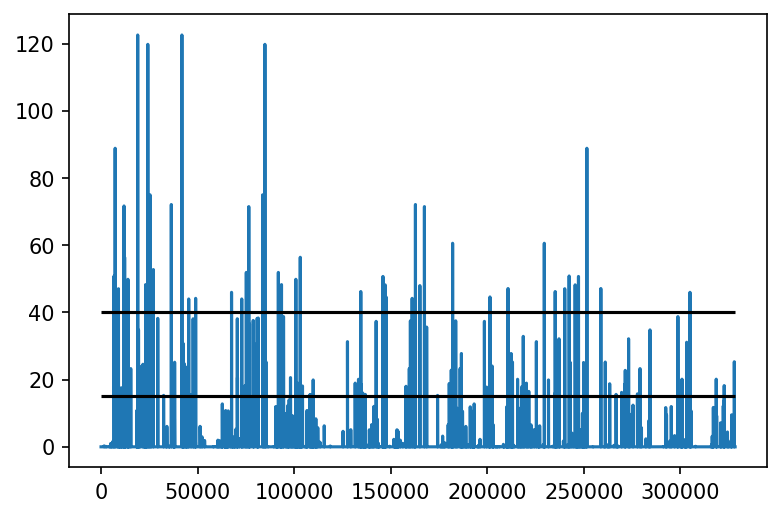

wrote network file negf_rep_incr.dat


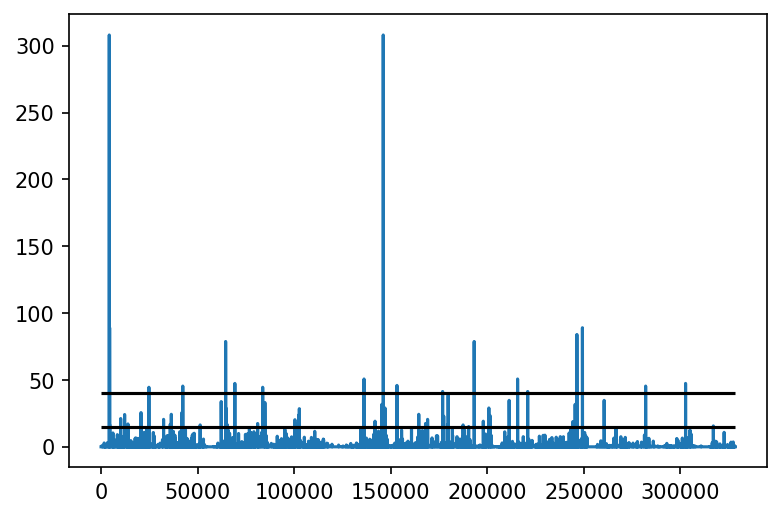

wrote network file negf_attr_incr.dat


In [34]:
refkey = "nof"
keylist = ["posf", "negf"]


for key in keylist:

    delta_pos_to_pos, delta_neg_to_neg, delta_pos_to_neg, delta_neg_to_pos = delta_F_case_by_case(
        key, refkey,
        check=True
    )
    
    ## write out network files
    array_to_network(np.where(delta_pos_to_pos > 0, delta_pos_to_pos, np.nan),
                     f"{key}_rep_incr.dat");
    array_to_network(np.where(delta_neg_to_neg > 0, delta_neg_to_neg, np.nan), 
                     f"{key}_attr_incr.dat"); # positive values in delta_neg_to_neg indicate increase in attr


# Consider absolute values of force matrix

In [13]:
def Delta_absF(key, refkey):
    """Form Delta Fij over the absolute force matrix 
    ==> we simply extract whether interaction strength increases or decreases
    """
    return neighbor_cutoff(
            np.nansum([abs(PF[key]['F_t_mean']), 
                       -abs(PF[refkey]['F_t_mean'])], 
                      axis=0), 
            n_ignore_neighbors)

In [14]:
def Delta_absF_to_network(key, refkey):
    d_absF = Delta_absF(key, refkey)

    array_to_network(np.where(d_absF > 0, d_absF, np.nan),
        f"PF/{key}_interact_incr.dat");
    array_to_network(np.where(d_absF < 0, -d_absF, np.nan),
        f"PF/{key}_interact_decr.dat");

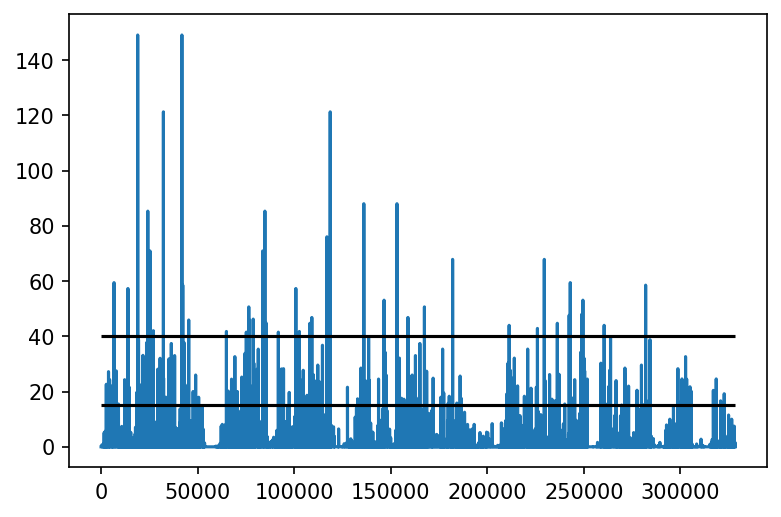

wrote network file z__redo_PF/posf_interact_incr.dat


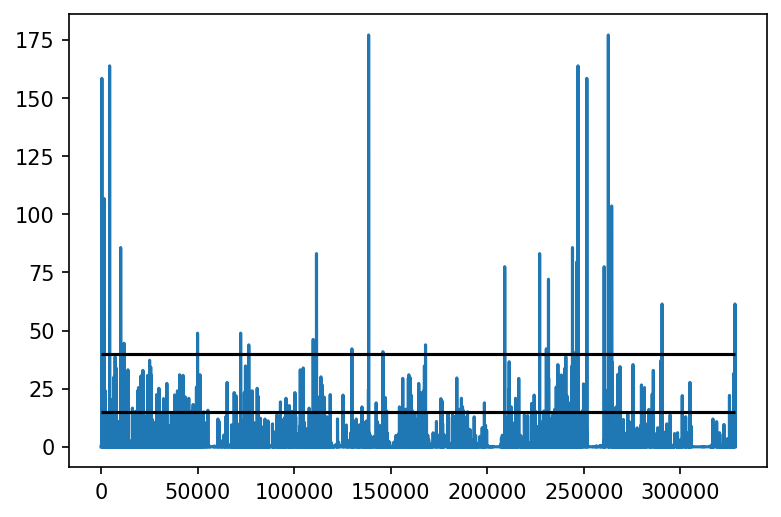

wrote network file z__redo_PF/posf_interact_decr.dat


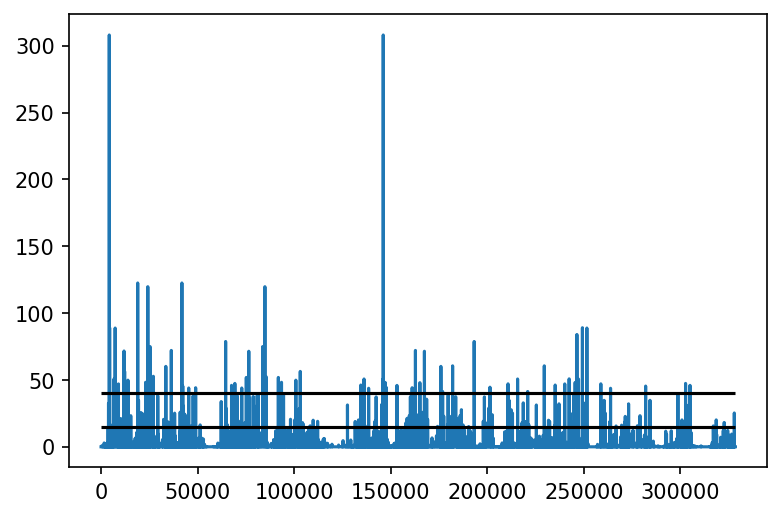

wrote network file z__redo_PF/negf_interact_incr.dat


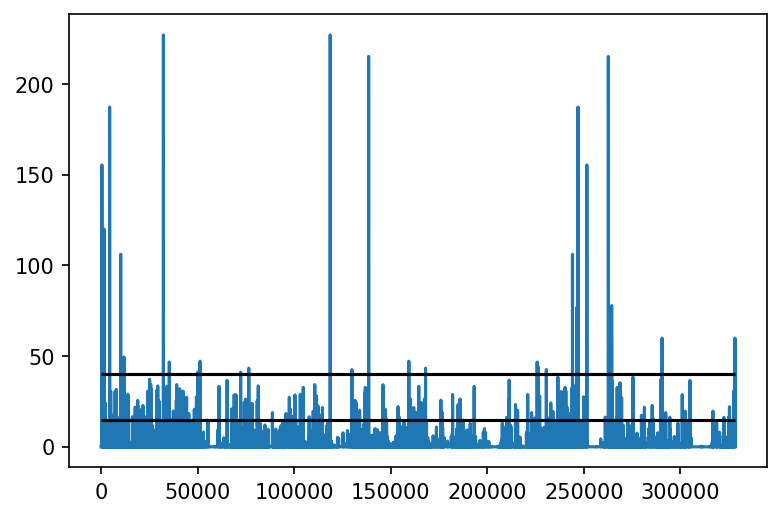

wrote network file z__redo_PF/negf_interact_decr.dat


In [35]:
for key in keylist:

    Delta_absF_to_network(key, refkey)

## L80D

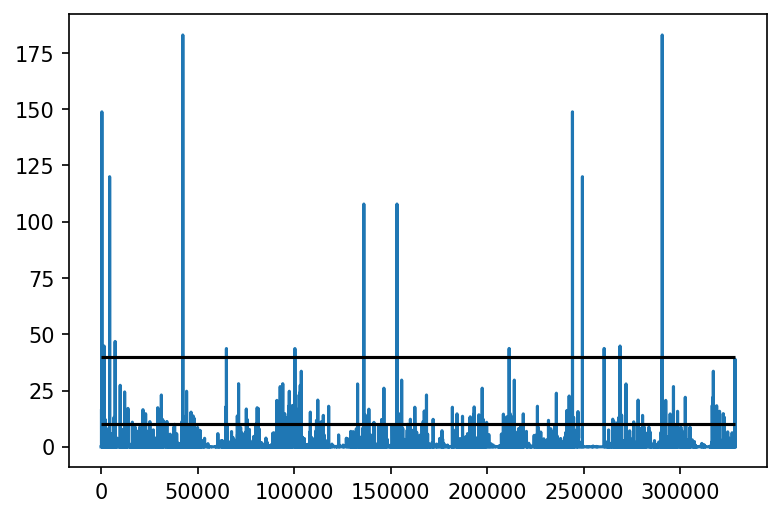

wrote network file z__redo_PF/L80D_field_interact_incr_cut10.dat


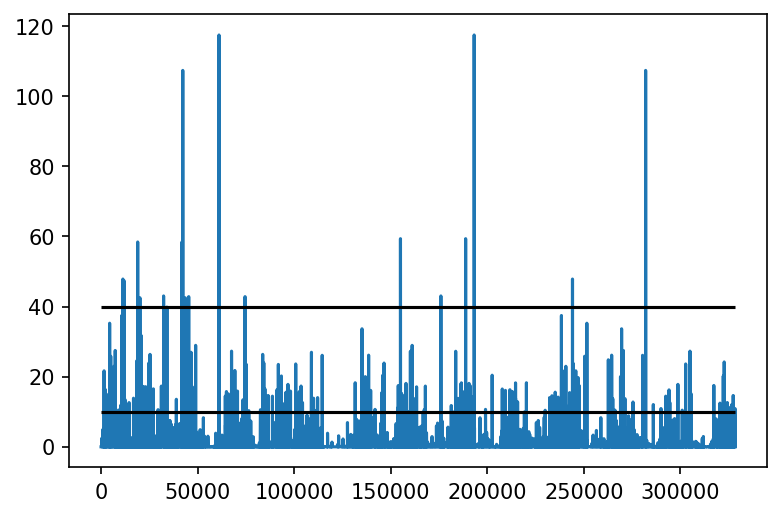

wrote network file z__redo_PF/L80D_field_interact_decr_cut10.dat


In [23]:
key = "L80D_field"
d_absF = Delta_absF('L80D_field', 'L80D_cMD',)

array_to_network(np.where(d_absF > 0, d_absF, np.nan),
    f"PF/{key}_interact_incr_cut10.dat", delta_force_lowercutoff=10);
array_to_network(np.where(d_absF < 0, -d_absF, np.nan),
    f"PF/{key}_interact_decr_cut10.dat", delta_force_lowercutoff=10);

## L80D field - WT posf comparison

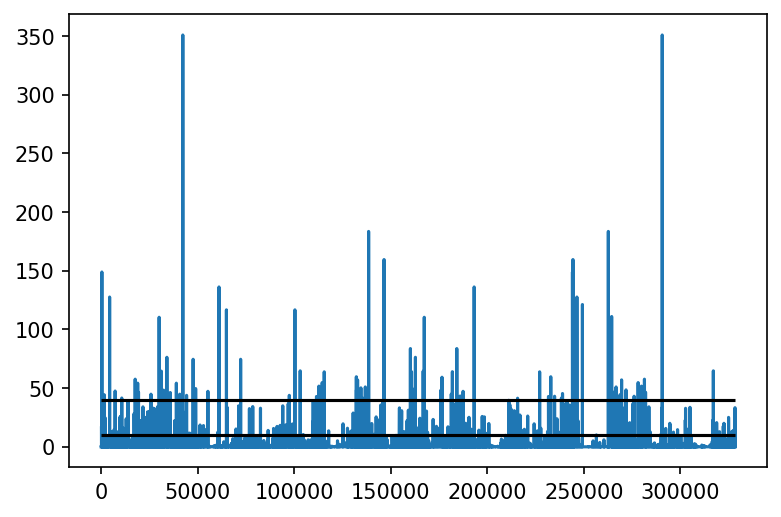

wrote network file z__redo_PF/L80Dfield_vs_posf_interact_incr_cut10.dat


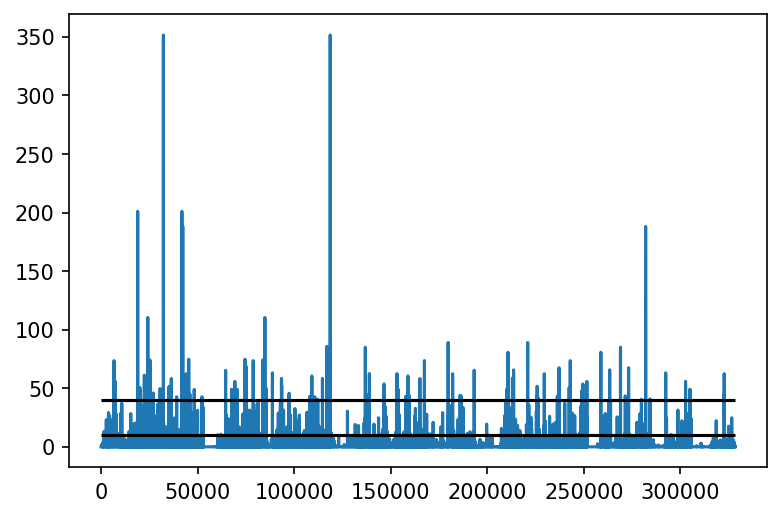

wrote network file z__redo_PF/L80Dfield_vs_posf_interact_decr_cut10.dat


In [24]:
d_absF = Delta_absF('L80D_field', 'posf',)

array_to_network(np.where(d_absF > 0, d_absF, np.nan),
    f"PF/L80Dfield_vs_posf_interact_incr_cut10.dat", delta_force_lowercutoff=10);
array_to_network(np.where(d_absF < 0, -d_absF, np.nan),
    f"PF/L80Dfield_vs_posf_interact_decr_cut10.dat", delta_force_lowercutoff=10);

475.1515253017491


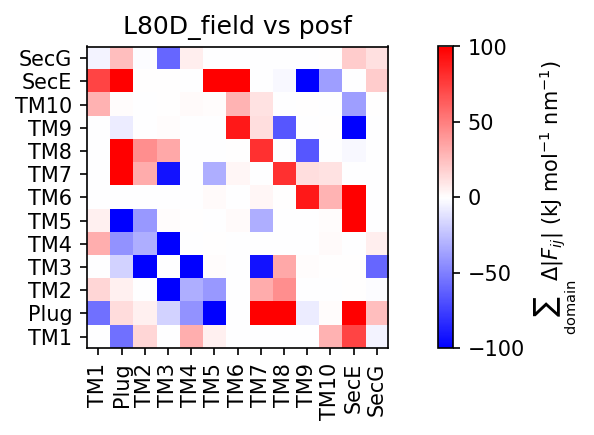

In [30]:
#### Compare to the simpler case of $|F_{ij}|$ (which disregards interactions pairs flipping from attractive to repulsive / vv.):

fig, ax = plt.subplots()
#fig.suptitle(r"Delta of $|F_{ij}|$")
#axes = axes.ravel()

a = "L80D_field"
b = "posf"
title = "L80D_field vs posf"
binned_forces_array = bin_PF_into_TMs(Delta_absF(a,b), "D_absF_forces_posf.png", show=False)[1]
absmax = max(np.nanmax(binned_forces_array), abs(np.nanmin(binned_forces_array)))
print(absmax)
absmax = 100
#im = plt.imshow(arr) #, vmin=-absmax, vmax=absmax, cmap='seismic')
im = ax.imshow(binned_forces_array[::-1], vmin=-absmax, vmax=absmax, cmap='bwr')

#fig.colorbar(im, ax=ax)
ax.set_title(title)
ax.set_xticks(range(len(binned_forces_array)))
ax.set_yticks(range(len(binned_forces_array)))
ax.set_xticklabels([d["n"] for d in _5gae_domains], rotation=90)
ax.set_yticklabels([d["n"] for d in _5gae_domains][::-1], rotation=0)
#fig.savefig(fname)
    
fig.colorbar(im, ax=ax,
                 label=r'$\sum_{\mathrm{domain}}\Delta |F_{ij}|$ (kJ mol$^{−1}$ nm$^{−1}$)')
fig.set_figwidth(7)
fig.set_figheight(3)
#axes[-1].axis("off")
fig.tight_layout()
#fig.savefig("Delta_absF_.png", dpi=300, bbox_inches="tight")
plt.show()

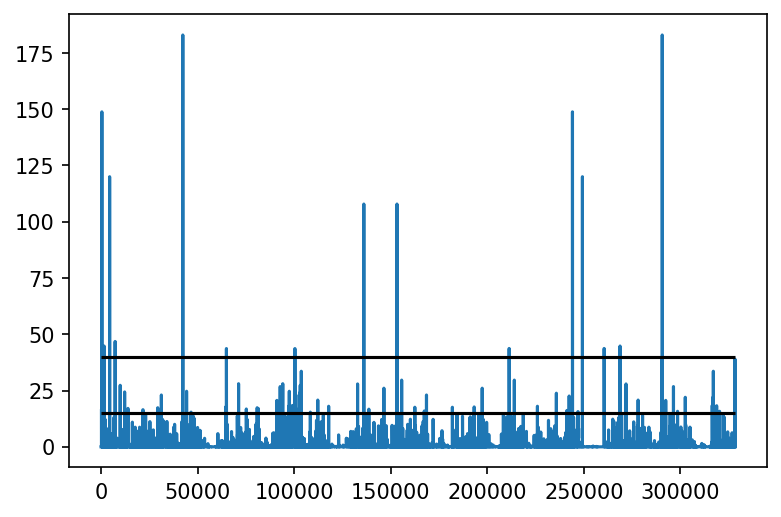

wrote network file z__redo_PF/L80D_field_interact_incr.dat


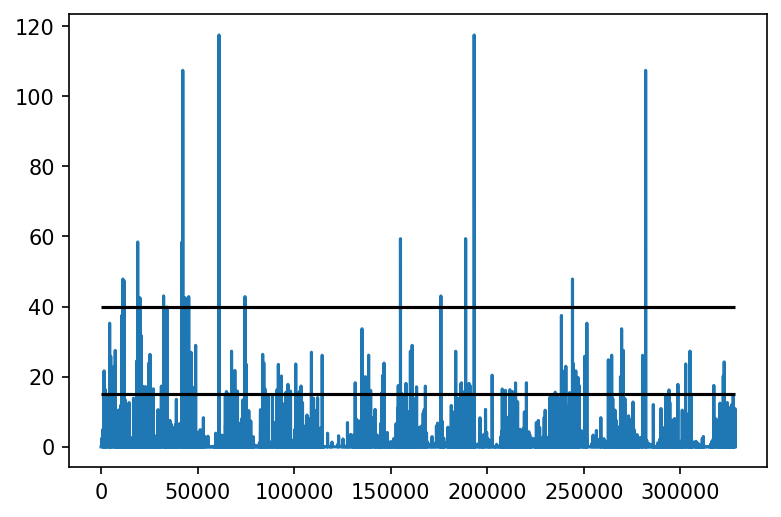

wrote network file z__redo_PF/L80D_field_interact_decr.dat
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


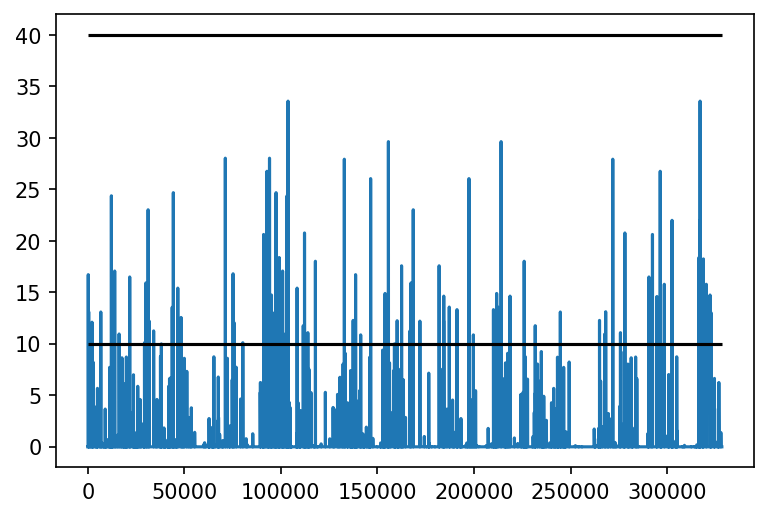

wrote network file z__redo_PF/L80D_field_rep_incr_cut10.dat


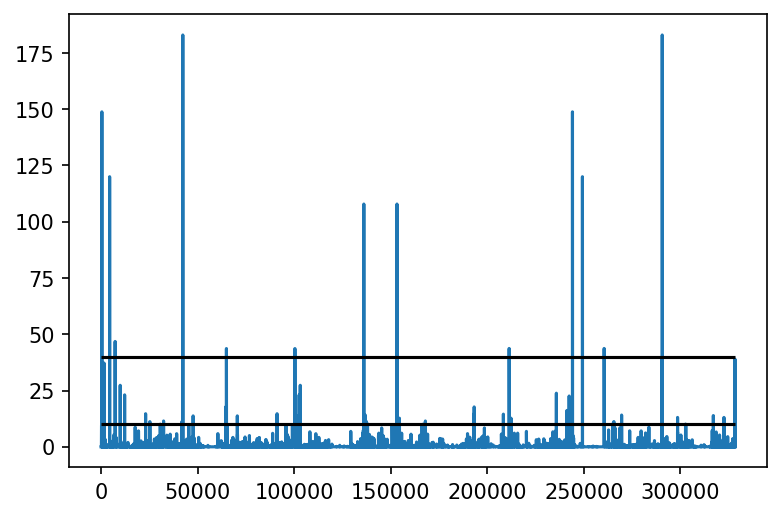

wrote network file z__redo_PF/L80D_field_attr_incr_cut10.dat


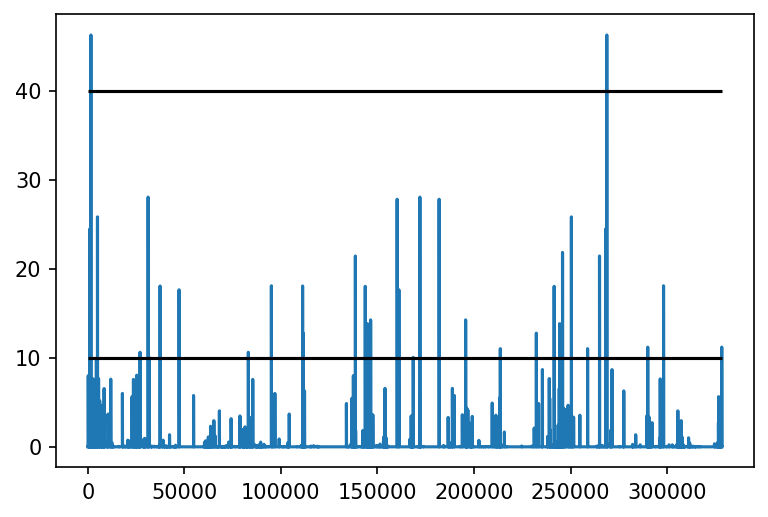

wrote network file z__redo_PF/L80D_field_postoneg_cut10.dat


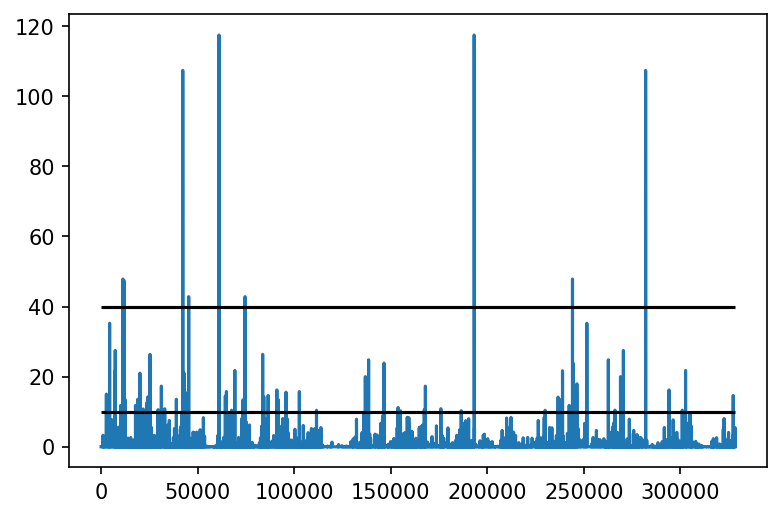

wrote network file z__redo_PF/L80D_field_attr_decr_redo_cut10.dat


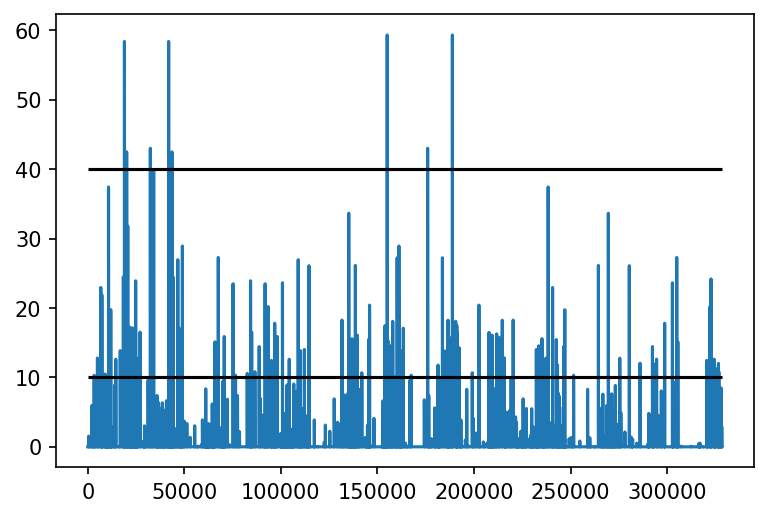

wrote network file z__redo_PF/L80D_field_rep_decr_redo_cut10.dat


In [22]:
key = "L80D_field"

Delta_absF_to_network('L80D_field', 'L80D_cMD',)

delta_pos_to_pos, delta_neg_to_neg, delta_pos_to_neg, delta_neg_to_pos = delta_F_case_by_case(
    'L80D_field', 'L80D_cMD',
    check=True
)

## write out network files
array_to_network(np.where(delta_pos_to_pos > 0, delta_pos_to_pos, np.nan),
                 f"PF/{key}_rep_incr_cut10.dat",
                delta_force_lowercutoff=10);
array_to_network(np.where(delta_neg_to_neg > 0, delta_neg_to_neg, np.nan), 
                 f"PF/{key}_attr_incr_cut10.dat",
                delta_force_lowercutoff=10); # positive values in delta_neg_to_neg indicate increase in attr
array_to_network(np.where(delta_pos_to_neg > 0, delta_pos_to_neg, np.nan),
                 f"PF/{key}_postoneg_cut10.dat",
                delta_force_lowercutoff=10)
array_to_network(np.where(delta_neg_to_neg < 0, -delta_neg_to_neg, np.nan),
             f"PF/{key}_attr_decr__cut10.dat",
                delta_force_lowercutoff=10);
array_to_network(np.where(delta_pos_to_pos < 0, -delta_pos_to_pos, np.nan),
                 f"PF/{key}_rep_decr__cut10.dat",
                delta_force_lowercutoff=10);